# MAS Final Homework Assignment
Daniel Engbert, Dec 2022

In [2]:
# helper function for use in code code below
import random
import numpy as np

def set_seed(seed=42):
  rng = random.Random()
  if seed is None:
    seed = random.randint(0, 9999)
  rng.seed(seed)
  np.random.seed(seed)

## Monte Carlo Estimation of Shapely Value

How to fairly split a taxi fare across $\{1, ... N\}$ players can be calculated using [Shapely values](https://en.wikipedia.org/wiki/Shapley_value), which treats this scenario as a cooperative game.
For this problem we assume that all players live on the way of the Nth player, and that player $A$ lives at distance of 1, player $B$ at a distance of 2, etc.

### Computing Shapely values for $n=4$:
The code below computes all permutations (a.k.a. "coalitions") of the $N=4$ players $\{A, B, C, D\}$, then for each permutation, `perm`, it assigns each player a share off the total payoff (the fare of total cost 4), by assuming player `perm[0]` showed up first at the taxi, followed by players `perm[1]`, `perm[2]`, `perm[3]`.

For example, for the permutation `perm = ['A', 'C', 'B', 'D']`, the respective payoffs (fare splits) will be `{'A': 1, 'B': 0, 'C': 2, 'D': 1}` (here player $B$ pays 0 because by the time he arrives at the taxi, it was already going to go by his house anyways due to player $C$.)

The final computed Shapely values are simply the average payoffs of each player across all possible permutations.


In [3]:
import random
import shapley

def get_player_vals(N: int):
    """
    Returns mapping of N player names (strings) to their distance along the taxi route.
    e.g. for N=4: {'A': 1, 'B': 2, 'C': 3', 'D': 4}
    """
    if N <= 26:
        return {chr(ord('A') + n): n+1 for n in range(0, N)}
    return {n+1: n+1 for n in range(0, N)}

def get_shapley(N: int):
    #player_vals = {'A': 6, 'B': 12, 'C': 42} # should result in shapely values {2, 5, 35}
    player_vals = get_player_vals(N)
    print(f"player_vals = {player_vals}")
    players = list(player_vals.keys())

    # list of permutations of coalitions of size len(players)
    perms = shapley.get_perms(players)
    print(f"there are {len(perms)} total permutations of {len(players)} players:")
    display(perms[:5]) # print first few rows
    print('(only the first 5 rows of permutations are shown above)')

    running_payoffs = {p: 0 for p in players}
    total_payoff = max(player_vals.values())
    for perm in perms:
        cur = {p: 0 for p in players}
        for p in perm: # compute share of payoff for each player in this permutation
            cur[p] = max(0, player_vals[p] - sum(cur.values()))
        running_payoffs = {k: v+cur[k] for (k,v) in running_payoffs.items()}

    shapely_values = {k: v/len(perms) for (k,v) in running_payoffs.items()}
    print(f"\nshapley_values: (for N = {N})")
    print(shapely_values)

    #print('percent of payoff:')
    #print({k: v/total_payoff for (k,v) in shapely_values.items()})

get_shapley(4)


player_vals = {'A': 1, 'B': 2, 'C': 3, 'D': 4}
there are 24 total permutations of 4 players:


[['A', 'B', 'C', 'D'],
 ['A', 'B', 'D', 'C'],
 ['A', 'C', 'B', 'D'],
 ['A', 'C', 'D', 'B'],
 ['A', 'D', 'B', 'C']]

(only the first 5 rows of permutations are shown above)

shapley_values: (for N = 4)
{'A': 0.25, 'B': 0.5833333333333334, 'C': 1.0833333333333333, 'D': 2.0833333333333335}


As can be seen from the output, the shapely values for $n=4$ players is `{'A': 0.25, 'B': 0.583, 'C': 1.083, 'D': 2.083}`

### Estimating Shapley values for $n=100$
Here we use [Monte Carlo sampling](https://en.wikipedia.org/wiki/Monte_Carlo_method) to approximiate the Shapely values for the taxi fare problem when $n=100$.


estimated shapley values: (for N = 50 players, and 10000 of permutations):
{1: 0.0222, 2: 0.0423, 3: 0.0582, 4: 0.0802, 5: 0.0982, 6: 0.1196, 7: 0.1539, 8: 0.1795, 9: 0.1917, 10: 0.2644, 11: 0.2372, 12: 0.2659, 13: 0.3015, 14: 0.3006, 15: 0.3614, 16: 0.4169, 17: 0.3982, 18: 0.4525, 19: 0.4001, 20: 0.4685, 21: 0.5361, 22: 0.5968, 23: 0.6383, 24: 0.6406, 25: 0.6851, 26: 0.7129, 27: 0.7791, 28: 0.8111, 29: 0.8952, 30: 0.8529, 31: 1.0053, 32: 1.006, 33: 1.0008, 34: 1.2031, 35: 1.1424, 36: 1.2506, 37: 1.3584, 38: 1.5389, 39: 1.4244, 40: 1.4711, 41: 1.6773, 42: 1.8337, 43: 1.9543, 44: 2.0115, 45: 2.1639, 46: 2.3938, 47: 2.6948, 48: 2.9949, 49: 3.5573, 50: 4.3564}

sum of estimated shapley values: 49.99999999999999


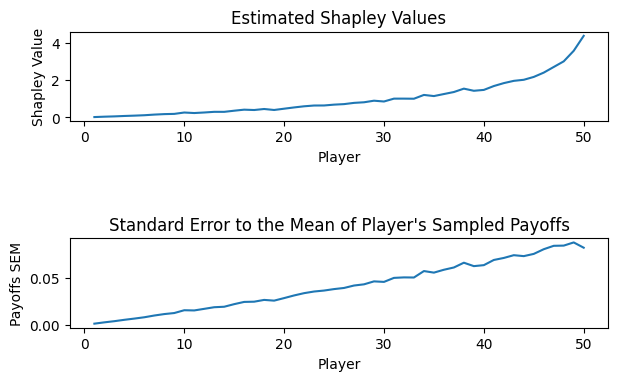

In [4]:
import matplotlib.pyplot as plt
import scipy

def estimate_shapley(N: int, samples: int):
    player_vals = get_player_vals(N)

    players = list(player_vals.keys())
    players_set = set(players)

    # store list of sampled payoffs for each player
    running_payoffs = {p: [] for p in players}
    total_payoff = max(player_vals.values())
    for _ in range(samples):
        perm = shapley.get_random_perm(players_set)
        cur = {p: 0 for p in players}
        for p in perm: # compute share of payoff for each player in this permutation
            cur[p] = max(0, player_vals[p] - sum(cur.values()))
            running_payoffs[p].append(cur[p])
        #running_payoffs = {k: v+cur[k] for (k,v) in running_payoffs.items()}

    shapely_values = {k: sum(pays)/samples for (k,pays) in running_payoffs.items()}
    print(f"\nestimated shapley values: (for N = {N} players, and {samples} of permutations):")
    print(shapely_values)
    print(f"\nsum of estimated shapley values: {sum(shapely_values.values())}")

    fig, axs = plt.subplots(2)
    fig.tight_layout(pad=6.0)
    fig.set_size_inches(8, 5)
    axs[0].set_title(f"Estimated Shapley Values")
    axs[0].set_xlabel(f'Player')
    axs[0].set_ylabel(f"Shapley Value")
    axs[0].plot(players, [shapely_values[p] for p in players])

    axs[1].set_title(f"Standard Error to the Mean of Player's Sampled Payoffs")
    axs[1].set_xlabel(f'Player')
    axs[1].set_ylabel(f"Payoffs SEM")
    sems = [scipy.stats.sem(pays) for player, pays in running_payoffs.items()]
    axs[1].plot(player_vals.keys(), sems)



estimate_shapley(50, 10000)

---
## Monte Carlo Tree Search (MCTS)

testing with c = 0.0
testing with c = 5.0


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

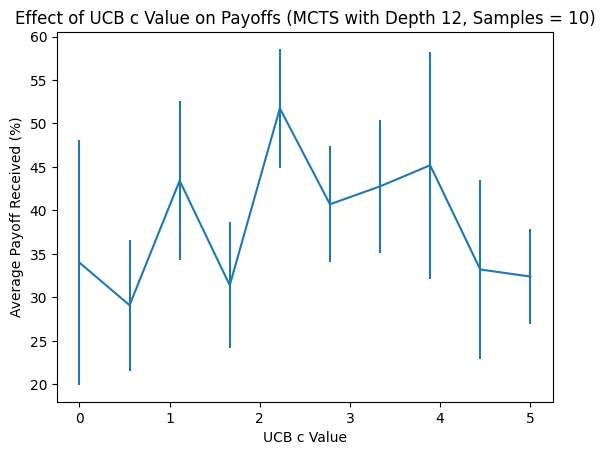

In [29]:
import math
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import statistics
import importlib
import tree_search as ts
importlib.reload(ts)

MCTS = ts.MCTS

###### experiment params
set_seed(None)
#depth = 10
depth = 4   # depth of tree to search
B = 25      # for computing values of leaf nodes
c = 2       # hyperparam
# TODO: define computational budget
######

#mc = MCTS(depth, c=c, B=B, draw=True)

def make_graph(data, show=True, save=False, samples=None):
  plt.clf()
  fig, ax = plt.subplots(1, 1)
  ax.set_xlabel("UCB c Value")
  ax.set_ylabel("Average Payoff Received (%)")
  ax.set_title(
      f"Effect of UCB c Value on Payoffs (MCTS with Depth {depth}, Samples = {samples})"
  )
  #ax.plot(data.keys(), data.values())
  # show standard deviation as total length of error bar
  ax.errorbar(data.keys(), [sum(d)/len(d) for d in data.values()], yerr=[statistics.stdev(d)/2 for d in data.values()])
  #ax.errorbar(data.keys(), [sum(d)/len(d) for d in data.values()], yerr=[50 for d in data.values()])
  if save:
    plt.savefig("c_graphs.pdf", dpi=400)
    #print("wrote c_graphs.pdf")
  if show:
    plt.show()


data = defaultdict(list)
depth = 12
NUM_SAMPLES = 5
for c in np.linspace(0, 5, num=10):
  if c % 0.25 == 0:
    print(f"testing with c = {c}")
  for _ in range(NUM_SAMPLES):
    mc = MCTS(depth, c=c, B=B)
    tra = mc.run()
    value = mc.tree.nodes[tra[-1]]["value"]
    target_value = mc.tree.nodes[mc.target_name]["value"]
    data[c].append(100 * value / target_value)
  make_graph(data, samples=NUM_SAMPLES, show=False, save=True)
make_graph(data, samples=NUM_SAMPLES, show=True, save=True)


#tree = ts.create_tree(depth, draw=True)
#nx.draw(tree, with_labels=True, node_size=300)



# now do MCTS:
# store in each node:
# {'values': []} # (also tells you num visits)


---
## RL: SARSA and Q-Learning

### Strategy 1: SARSA with Greedification
For the first experiment, SARSA is used in combination with greedification to search for an optimal policy.


In [38]:
import importlib
import matplotlib.pyplot as plt
import qlearn as ql
importlib.reload(ql)

sim = ql.QLearn()
#sim.visualize_qtable()

# TODO:

### Q-Learning

#### Strategy 2a: Direct Updates
Here we directly update the Q-table while rolling out each sample path.

Specifically we simulate `ITERATIONS` episodes (starting at a random initial position each time) and perform q-learning with $\epsilon$-greedy selection) until each episode terminates.

initial Q table:


,s,a,r,q
0,"(0, 0)",3.0,-1.0,1.352051
1,"(0, 0)",1.0,-1.0,0.259216
2,"(0, 0)",0.0,-1.0,1.820377
3,"(0, 0)",2.0,-1.0,0.390505
4,"(0, 1)",3.0,-1.0,0.106118
...,...,...,...,...
319,"(8, 7)",2.0,-1.0,1.450301
320,"(8, 8)",3.0,50.0,0.000000
321,"(8, 8)",1.0,50.0,0.000000
322,"(8, 8)",0.0,50.0,0.000000


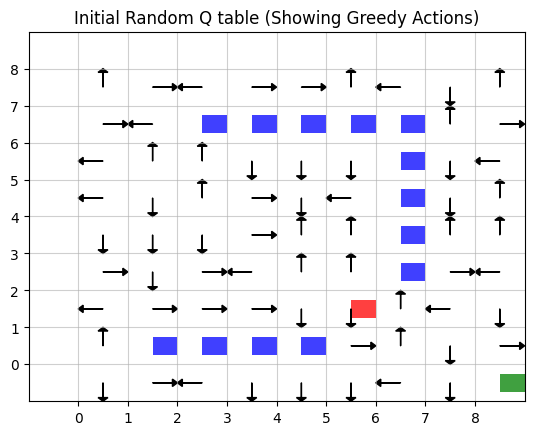

new Q table:


,s,a,r,q
0,"(0, 0)",3.0,-1.0,-2.990689
1,"(0, 0)",1.0,-1.0,-2.991275
2,"(0, 0)",0.0,-1.0,-2.990615
3,"(0, 0)",2.0,-1.0,-2.991360
4,"(0, 1)",3.0,-1.0,-2.992087
...,...,...,...,...
319,"(8, 7)",2.0,-1.0,-1.473547
320,"(8, 8)",3.0,50.0,0.000000
321,"(8, 8)",1.0,50.0,0.000000
322,"(8, 8)",0.0,50.0,0.000000


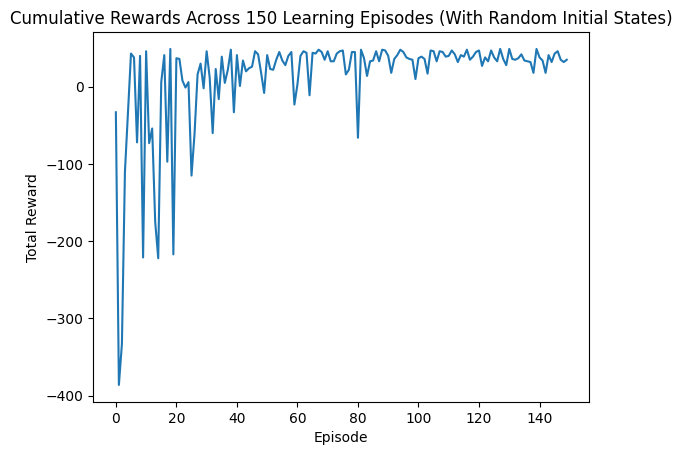

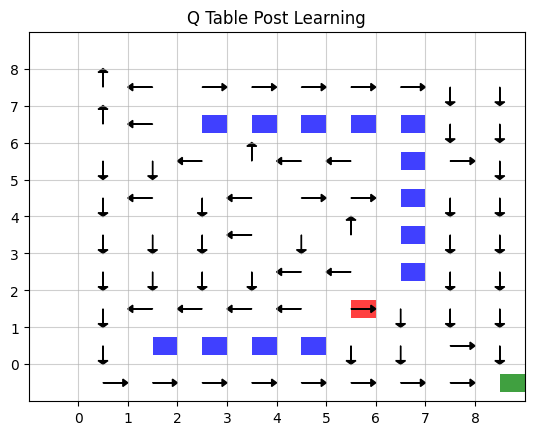

Text(0, 0.5, 'Reward')

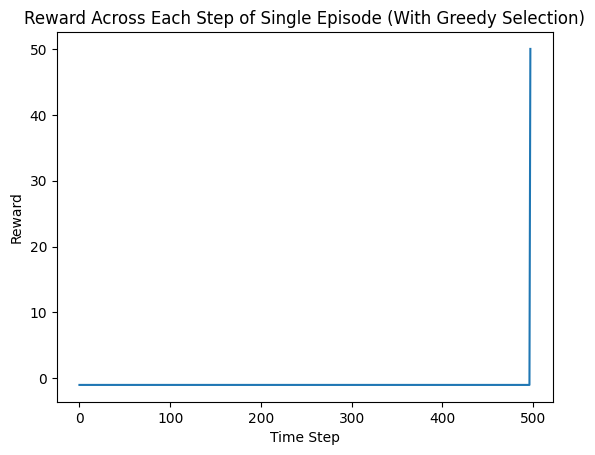

In [42]:
import importlib
import matplotlib.pyplot as plt
import qlearn as ql
importlib.reload(ql)

ITERATIONS = 150

sim = ql.QLearn()
#world = ql.create_world()
print(f"initial Q table:")
display(sim.qtable)
sim.visualize_qtable(title="Initial Random Q table (Showing Greedy Actions)")

s0 = (0,0)
rewards = []
for _ in range(ITERATIONS):
  rewards.append(sim.run_episode()[0])
  #rewards.append(sim.run_episode(s0=s0))

plt.title(f'Total Rewards Across {ITERATIONS} Learning Episodes (With Random Initial States)')
plt.plot(range(0, len(rewards)), [sum(r) for r in rewards])
plt.xlabel('Episode')
plt.ylabel('Total Reward')

print(f"new Q table:")
display(sim.qtable)
sim.visualize_qtable(title="Q Table Post Learning")


plt.title(f'Reward Across Each Step of Single Episode (With Greedy Selection)')
step_rewards = sim.run_episode(s0=s0, epsilon=1.0)[0]
plt.plot(range(0, len(step_rewards)), step_rewards)
plt.xlabel('Time Step')
plt.ylabel('Reward')


#### Strategy 2b: Replay Buffer
Here we collect experiences by simulating episodes (without learning), and then sample from the stored experiences to perform Q-learning.

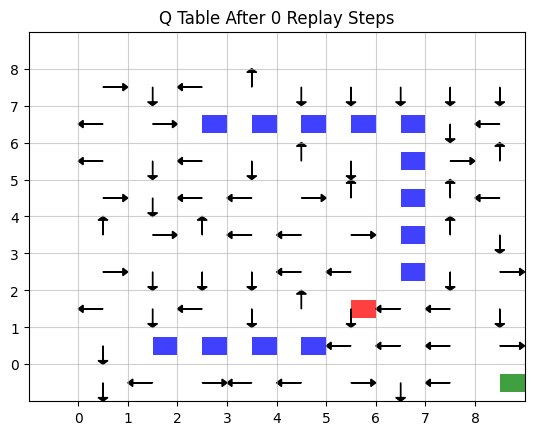

collected 10000 experiences to sample from.


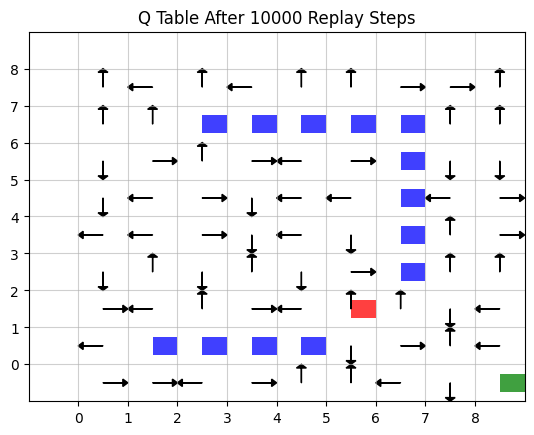

In [57]:
import qlearn as ql
importlib.reload(ql)
#sim = ql.QLearn()

ql.strategy2b()

### Discussion

TODO: Compare the solutions and the corresponding computational effort for the three solution
strategies.

TODO: make a fitness func() for evaluating a qtable by evaluating it on N experiences from random locations...

Add up the number of (learning) steps needed for each strategy to reach a given fitness.